# Import all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import requests
import nltk
import string
import re
import math
import operator
import os
import csv

from IPython.display import Image 
from itertools import compress
from sklearn.cluster import KMeans 
from pylab import rcParams
from collections import Counter
from nltk.corpus import stopwords
from sklearn import neighbors, tree
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation
from bs4 import BeautifulSoup

from sklearn import metrics
import pydotplus

from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
kv_pairs_all = {}

In [3]:
# A function that strips all html tags
def striphtml(dat):
    p = re.compile(r'<.*?>') # Regular expression for all html tags
    return p.sub(' ', dat)

# A function that modifies multiple spaces into a single space
def removespace(dat):
    p = re.compile(' +')
    return p.sub(' ', dat)

def get_filtered(sen):
    sentence = sen
    lower = sentence.lower()
    no_punctuation = re.sub(r'[^\w\s]','',lower)
    no_numbers = ''.join([w for w in no_punctuation if not w.isdigit()])
    tokens = nltk.word_tokenize(no_numbers)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered

def unlist(ls):
    output = ''
    for v in ls:
        output = output + " " + v
    return output.strip()

# Euclidean Distance
def distance(p0, p1):
    return np.linalg.norm(p0 - p1)

In [4]:
# Read teaching files and grab all RadLex terms
def RSNA_parse3(url):
    
    conn_term = ""
    with urllib.request.urlopen(url) as url:
        sou = url.read()
        soup = BeautifulSoup(sou)
        
    global kv_pairs_all
    
    big_title = soup.find_all('h1')[0].text # title of TF
    title = soup.find_all('h2') # This is a title for each category (ddx, findings...)
    title[0] = 'Document'

    temp2 = soup.find_all('div', class_ = "hide")
    
    for i in range(len(temp2)):
        content = temp2[i].find_all('a')
        for j in range(len(content)):
            # append terms (ex) abnormal chest becomes abnormal_chest
            if len(content[j].string.split(' ')) > 1:
                temp = content[j].string.replace(' ', '_').lower()+" "
                conn_term += temp
                if temp not in kv_pairs_all.keys():
                    kv_pairs_all[temp] = 1
                else:
                    kv_pairs_all[temp] = kv_pairs_all[temp] + 1
            else:
                temp = content[j].string.lower()+" "
                conn_term += temp
                if temp not in kv_pairs_all.keys():
                    kv_pairs_all[temp] = 1
                else:
                    kv_pairs_all[temp] = kv_pairs_all[temp] + 1
                 
    conn_term = conn_term.strip()
    
    return [big_title, conn_term]

# Extract xml files and store all RadLex terms

In [5]:
# Type any keyword in 'query' variable
query = ''
payload = {'firstresult':'1', 'maxresults':'5000','orderby':'1','server':'0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:20:21:22','document':query} # Query
r2 = requests.post("http://mirc.rsna.org/query", data=payload)

In [6]:
# Convert into a beautifulsoup object
bbs = BeautifulSoup(r2.text, "lxml")
corpus = []

In [7]:
kv_pairs_all = {}
for xml in bbs.find_all("a", href = True):
    ter = RSNA_parse3(xml['href'])
    corpus.append(ter)

In [8]:
title_ls = []
all_words = []

for i in range(len(corpus)):
    # By creating a dictionary I can keep track of the index of teaching file

    # append title
    title_ls.append(corpus[i][0])
    
    temp_dic = {}
    temp_dic[i] = corpus[i][1]
    all_words.append(temp_dic)

In [9]:
# Now create a list of words
all_w = []
for k in range(len(all_words)):
    all_w.append(list(all_words[k].values())[0].strip())

# Term-Frequency Matrix Generator

In [10]:
# Function to calculate TF-IDF
def TFIDF_generator(w, word_list):
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(w)
    
    df = pd.DataFrame(X.toarray(), columns= vectorizer.get_feature_names())
    
    # Get the index of History category
    idx = [list(word_list[x].keys())[0] for x in range(len(word_list))]
    
    df.index = [title_ls[i] for i in idx]
    
    # Now I have a term-frequency matrix with TF index!!!!
    TF = df.T
    
    # Calculate the number of TFs and terms
    numTerms = TF.shape[0]
    nTF = TF.shape[1]
    
    # create IDF
    DF = np.array([(TF!=0).sum(1)]).T
    
    # Create a matrix with all entries to be the number of TFs
    NMatrix=np.ones(np.shape(TF), dtype=float)*nTF
    np.set_printoptions(precision=2,suppress=True,linewidth=120)

    # Convert each entry into IDF values
    # Note that IDF is only a function of the term, so all rows will be identical.
    IDF = np.log2(np.divide(NMatrix, DF))

    # Calculate TF-IDF
    TFIDF = TF * IDF
    
    return TF, TFIDF

In [11]:
all_tf, all_tfidf = TFIDF_generator(all_w, all_words)

In [12]:
all_tf.T.to_csv("all_term_freq.csv")

# Decision Tree to decide # Clusters

In [13]:
def DTree_Calculate_Accr(df, z):
    acc_ls = []
    
    for t in range(2, 300, 2):
        # Figure out the membership of each cluster
        membership = fcluster(z, t, criterion='maxclust')
        temp_tf = df.T
        temp_tf['Membership'] = membership.tolist()  

        # Remove all cases where the total count is 1
        if np.sum(temp_tf.Membership.value_counts() >= 1):
            # Extract cluster membership that does have more than one observation
            list_a = [x for x in range(1,t+1)]
            fil = temp_tf['Membership'].value_counts() != 1
            # Sort by dataframe index
            fil.sort_index(inplace=True)
            cm_needed_ls = list(compress(list_a, fil))

            # Boolean index to filter out
            haha = [True if x in cm_needed_ls else False for x in temp_tf['Membership']]

            # Our final df
            final_dt = temp_tf[haha]

            x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(final_dt,
                            final_dt['Membership'],train_size=.8, stratify=final_dt['Membership'], random_state = 33)
        else:
            x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(temp_ddx_tf,
                temp_ddx_tf['Membership'],train_size=.8, stratify=temp_tf['Membership'], random_state = 33)

        treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=30)
        treeclf = treeclf.fit(x_train, tar_train)

        # Accuracy on Test Set
        acc = treeclf.score(x_test, tar_test)
        acc_ls.append(acc)
        print('Tree ', t, ' has ',acc,' accuracy!')
        
#         #treecm = confusion_matrix(tar_test, treepreds_test)    
        
    return acc_ls, temp_tf, membership

In [15]:
# Scree plot for accuracy
Z = linkage(all_tf.T, 'ward') 
acc, td, memb = DTree_Calculate_Accr(all_tf, Z)

Tree  2  has  1.0  accuracy!
Tree  4  has  1.0  accuracy!
Tree  6  has  1.0  accuracy!
Tree  8  has  0.998043052838  accuracy!
Tree  10  has  0.996086105675  accuracy!
Tree  12  has  0.998043052838  accuracy!
Tree  14  has  0.998039215686  accuracy!
Tree  16  has  0.998043052838  accuracy!
Tree  18  has  0.99217221135  accuracy!
Tree  20  has  0.99217221135  accuracy!
Tree  22  has  0.992141453831  accuracy!
Tree  24  has  0.992156862745  accuracy!
Tree  26  has  0.990176817289  accuracy!
Tree  28  has  0.988212180747  accuracy!
Tree  30  has  0.990176817289  accuracy!
Tree  32  has  0.984251968504  accuracy!
Tree  34  has  0.988188976378  accuracy!
Tree  36  has  0.978388998035  accuracy!
Tree  38  has  0.974459724951  accuracy!
Tree  40  has  0.970530451866  accuracy!
Tree  42  has  0.970530451866  accuracy!
Tree  44  has  0.96463654224  accuracy!
Tree  46  has  0.96463654224  accuracy!
Tree  48  has  0.956692913386  accuracy!
Tree  50  has  0.952848722986  accuracy!
Tree  52  has  0

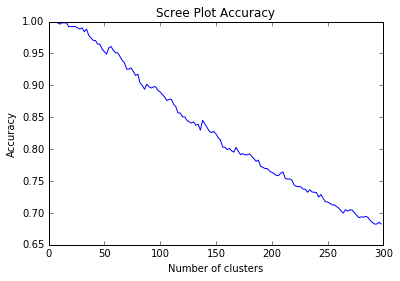

In [16]:
plt.plot([x for x in range(2, 300, 2)], acc)
plt.title('Scree Plot Accuracy')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

# Hierarchical Clustering & Dendrogram

In [17]:
# generate the linkage matrix
Z = linkage(all_tf.T, 'ward')

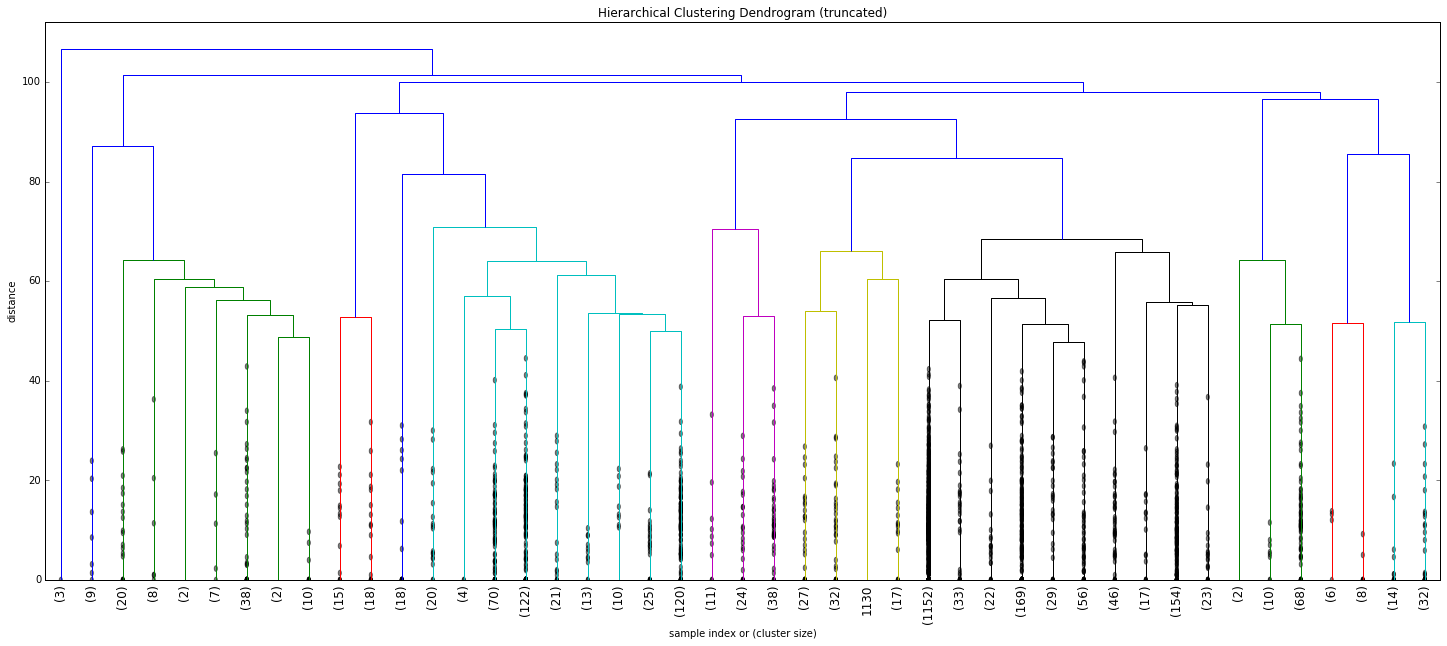

In [18]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=45,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [19]:
membership = fcluster(Z, 45, criterion='maxclust')
temp_tf = all_tf.T
temp_tf['Membership'] = membership.tolist() 

# Remove first two irrelevant columns
temp_tf = temp_tf.ix[:,2:]

ddf = temp_tf
three_most_freq_terms = []

# Cluster Analysis

In [20]:
# Iterate through all clusters
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,46):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in all_tf.columns]
    term_lists = [all_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 

    clean_count_asdict = count_asdict
    three_most_freq_terms.append(count_asdict[:8])

In [21]:
# Calculate within-ratio for each cluster
for c in range(1, 46):
    subset_cluster = ddf[ddf['Membership'] == c]
    km = KMeans(n_clusters=1, max_iter=1, random_state=33)
    q = km.fit(subset_cluster.ix[:,subset_cluster.columns != "Membership"])
    print("Cluster"+str(c))
    print(q.inertia_ / (subset_cluster.shape[0] - 1))

Cluster1
0.0
Cluster2
185.138888889
Cluster3
108.476315789
Cluster4
262.5
Cluster5
0.0
Cluster6
161.571428571
Cluster7
162.155049787
Cluster8
4.0
Cluster9
55.1555555556
Cluster10
110.60952381
Cluster11
143.947712418
Cluster12
143.307189542
Cluster13
138.665789474
Cluster14
0.0
Cluster15
114.566666667
Cluster16
145.181343991
Cluster17
174.061904762
Cluster18
54.8974358974
Cluster19
202.566666667
Cluster20
78.6733333333
Cluster21
102.908963585
Cluster22
199.890909091
Cluster23
125.219202899
Cluster24
143.63086771
Cluster25
111.407407407
Cluster26
159.108870968
Cluster27
99.2205882353
Cluster28
nan
Cluster29
77.0232874192
Cluster30
151.151515152
Cluster31
75.79004329
Cluster32
135.801070724
Cluster33
162.352216749
Cluster34
161.930844156
Cluster35
130.953140097
Cluster36
115.169117647
Cluster37
100.429462694
Cluster38
105.162055336
Cluster39
0.0
Cluster40
39.5888888889
Cluster41
159.370280948
Cluster42
101.3
Cluster43
53.9464285714
Cluster44
70.5714285714
Cluster45
82.5463709677


# RadLex Category Tracker

In [22]:
example = []
for terms in three_most_freq_terms:
    for term in terms:
        if term[0] == "":
            example.append("abscess")
        elif term[0] == "polyp":
            example.append("lateral")
        else:
            example.append(term[0])

# Remove all underline
example = [tm.replace("_", " ") for tm in example]

In [23]:
# Modify some terms in a list
flag = 0
for x, tt in enumerate(example):
    if flag == 0 and tt == "fossa":
        example[x] = "fourth ventricle"
        flag = 1
        print("CHANGE")
    elif flag == 1 and tt == "fossa":
        example[x] = "fourth ventricle"
        flag = 2
        print("CHANGE one more")

In [25]:
# Re-define variable
radlex_term_category_list = pd.read_csv("Radlex.csv", encoding='latin-1', sep='\s*\t\s*')

In [26]:
term_category_dict = {}
clus_idx = 1
for x, term in enumerate(example):
    hier = ""
    terms = ""

    target = radlex_term_category_list[radlex_term_category_list["Name or Synonym"].values == term]
    hier += target["Name or Synonym"].values+" => "
    terms += target["Name or Synonym"].values+","
    # Loop through until it reaches to the root

    try:
        while target["Parent RID"].values[0] != "RID1":
            parent_rid = target["Parent RID"].values[0]
            target = radlex_term_category_list[radlex_term_category_list["RID"] == parent_rid]
#             print(target)
            hier += target["Name or Synonym"].values+" => "
            terms += target["Name or Synonym"].values+","

        terms_list = unlist(terms).strip().split(",")

        terms_list = terms_list[1:-1]

        if terms_list[-1] not in term_category_dict.keys():
            term_category_dict[terms_list[-1]] = {}
            for term in terms_list:
                if term not in term_category_dict[terms_list[-1]].keys():
                    term_category_dict[terms_list[-1]][term] = 1
                else:
                    term_category_dict[terms_list[-1]][term] += 1
        else:
            for term in terms_list:
                if term not in term_category_dict[terms_list[-1]].keys():
                    term_category_dict[terms_list[-1]][term] = 1
                else:
                    term_category_dict[terms_list[-1]][term] += 1

        if x % 8 == 0:
            print("============CLUSTER "+str(clus_idx)+"==============")
            print("===============")
            clus_idx += 1

        print(hier)
    except IndexError:
        continue

============CLUSTER 1==============
[ 'talus => tarsal bone => short bone => bone organ => organ with cavitated organ parts => cavitated organ => organ => anatomical structure => material anatomical entity => anatomical entity => ']
['congenital => disease origin descriptor => Radlex descriptor => ']
['normal => normality descriptor => Radlex descriptor => ']
[ 'calcaneus => tarsal bone => short bone => bone organ => organ with cavitated organ parts => cavitated organ => organ => anatomical structure => material anatomical entity => anatomical entity => ']
['vertical => orientation descriptor => Radlex descriptor => ']
[ 'forefoot => segment of foot => free lower limb region => free limb region => limb region => subdivision of cardinal body part => anatomical structure => material anatomical entity => anatomical entity => ']
[ 'hindfoot => segment of foot => free lower limb region => free limb region => limb region => subdivision of cardinal body part => anatomical structure => materia

In [27]:
size_cluster = len(np.unique(ddf['Membership']))

for c in range(1,46):
    subset_cluster = ddf[ddf['Membership'] == c]
    
    spec_tf = [True if x in subset_cluster.index else False for x in all_tf.columns]
    term_lists = [all_w[i] for i, x in enumerate(spec_tf) if x]
    wc = {}
    for term_list in term_lists:
        wwc = term_list.split(' ')
        for term in wwc:
            if term == 'trauma' or term == 'tumor' or term == 'surgery' or term == 'inguinal_hernia' or term == 'bones':
                continue
            else:
                if term.lower() not in wc.keys():
                    wc[term.lower()] = 1
                else:
                    wc[term.lower()] = wc[term.lower()] + 1

    count_asdict = sorted(wc.items(), key = lambda x: x[1], reverse = True) 
    
    clean_count_asdict = count_asdict
    print(str(c)+"!++++++++++++++++++++++++++++")
    print(count_asdict)
    print("++++++++++++++++++++++++++")
    three_most_freq_terms.append(count_asdict[:8])

1!++++++++++++++++++++++++++++
[('talus', 75), ('congenital', 51), ('normal', 36), ('calcaneus', 36), ('vertical', 33), ('forefoot', 33), ('hindfoot', 27), ('metatarsal', 27), ('lateral', 27), ('flexion', 15), ('right', 15), ('first', 15), ('displaced', 15), ('may_be', 15), ('parallel', 15), ('deformity', 12), ('angle', 12), ('dorsal', 9), ('abnormal', 9), ('decreased', 9), ('ap_view', 9), ('convex', 6), ('proximal', 6), ('horizontal', 6), ('increased', 6), ('severe', 6), ('dislocation', 6), ('lateral_projection', 6), ('anterior', 6), ('follow-up', 3), ('place', 3), ('anteroposterior_projection', 3), ('lateral_cuneiform', 3), ('cuboid', 3), ('narrowing', 3), ('plantar_arch', 3), ('inverted', 3), ('routine', 3), ('second', 3), ('sagittal_plane', 3), ('ankle', 3), ('persistent', 3), ('unknown', 3), ('tibia', 3), ('medial', 3), ('amount', 3), ('dislocated', 3)]
++++++++++++++++++++++++++
2!++++++++++++++++++++++++++++
[('coarctation', 148), ('aorta', 88), ('distal', 36), ('narrowing', 35)

# Decision Tree Generator

In [28]:
# Figure out the membership of each cluster
membership = fcluster(Z, 45, criterion='maxclust')
temp_tf = all_tf.T
temp_tf['Membership'] = membership.tolist() 

In [30]:
for c in range(1, 46):
    temp_tf['Membership'] = membership.tolist() 
    temp_tf.loc[temp_tf['Membership'] != c, 'Membership'] = 0
    temp_tf.loc[temp_tf['Membership'] == c, 'Membership'] = 1
    
    x_train, x_test, tar_train, tar_test = cross_validation.train_test_split(all_tf.T,
        temp_tf['Membership'], train_size=.8, random_state = 33)

    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])
    
    # retrieve sig terms in decision tree
    sig_feature_idx = list(set([x for x in list(treeclf.tree_.feature) if x != -2]))
    # print terms
    print("Cluster "+str(c)+" : "+all_tf.index[sig_feature_idx])

    with open("all"+str(c)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)
        
    os.unlink("all"+str(c)+".dot")
    
    # analyze this with Priya and Sungmin
   # dot_data = tree.export_graphviz(treeclf, out_file=None) 
   # graph = pydotplus.graph_from_dot_data(dot_data) 
   # graph.write_pdf("all"+str(c)+".pdf") 

Index(['Cluster 1 : lateral_projection'], dtype='object')
Index(['Cluster 2 : coarctation'], dtype='object')
Index(['Cluster 3 : aortic_arch', 'Cluster 3 : subclavian_artery'], dtype='object')
Index(['Cluster 4 : pulmonary_artery'], dtype='object')
Index(['Cluster 5 : margin'], dtype='object')
Index(['Cluster 6 : portal_vein'], dtype='object')
Index(['Cluster 7 : right_atrium', 'Cluster 7 : mixed',
       'Cluster 7 : congenital', 'Cluster 7 : ventricular_septal_defect',
       'Cluster 7 : vascularity', 'Cluster 7 : heart_disease',
       'Cluster 7 : ferguson'],
      dtype='object')
Index(['Cluster 8 : sclera'], dtype='object')
Index(['Cluster 9 : pulmonary_veins'], dtype='object')
Index(['Cluster 10 : torsion', 'Cluster 10 : ovary'], dtype='object')
Index(['Cluster 11 : testis'], dtype='object')
Index(['Cluster 12 : tumor'], dtype='object')
Index(['Cluster 13 : osteomyelitis'], dtype='object')
Index(['Cluster 14 : right_optic_nerve'], dtype='object')
Index(['Cluster 15 : pheochromo

In [31]:
all_tf.T.columns[1609]

'intussusception'

# Category Analysis

## Separate into 9 big clusters

In [32]:
# Big clusters
big_clus1_df = ddf[ddf.Membership <= 9]
big_clus2_df = ddf[ddf.Membership >= 10]
big_clus2_df = big_clus2_df[big_clus2_df.Membership <= 11]
big_clus3_df = ddf[ddf.Membership >= 12]
big_clus3_df = big_clus3_df[big_clus3_df.Membership <= 22]
big_clus4_df = ddf[ddf.Membership >= 23]
big_clus4_df = big_clus4_df[big_clus4_df.Membership <= 24]
big_clus5_df = ddf[ddf.Membership >= 25]
big_clus5_df = big_clus5_df[big_clus5_df.Membership <= 26]
big_clus6_df = ddf[ddf.Membership >= 27]
big_clus6_df = big_clus6_df[big_clus6_df.Membership <= 29]
big_clus7_df = ddf[ddf.Membership >= 30]
big_clus7_df = big_clus7_df[big_clus7_df.Membership <= 32]
big_clus8_df = ddf[ddf.Membership >= 33]
big_clus8_df = big_clus8_df[big_clus8_df.Membership <= 36]
big_clus9_df = ddf[ddf.Membership >= 37]

In [33]:
idx = 1

In [34]:
def Separate_Clusters(df):
    global idx
    big_clus_freq = {}
    for row in range(df.shape[0] - 1):
        temp_row = df.ix[row,:]
        for a in range(df.shape[1] - 2):
            if temp_row.index[a] not in big_clus_freq.keys():
                big_clus_freq[temp_row.index[a]] = temp_row[a]
            else:
                big_clus_freq[temp_row.index[a]] += temp_row[a]   
    big_clus = pd.Series(big_clus_freq, index=big_clus_freq.keys())
    big_clus.to_csv("big_clus"+str(idx)+".csv")
    print("big_clus"+str(idx)+".csv file saved!")
    idx += 1 

In [35]:
Separate_Clusters(big_clus1_df)
Separate_Clusters(big_clus2_df)
Separate_Clusters(big_clus3_df)
Separate_Clusters(big_clus4_df)
Separate_Clusters(big_clus5_df)
Separate_Clusters(big_clus6_df)
Separate_Clusters(big_clus7_df)
Separate_Clusters(big_clus8_df)
Separate_Clusters(big_clus9_df)

idx = 1

big_clus1.csv file saved!
big_clus2.csv file saved!
big_clus3.csv file saved!
big_clus4.csv file saved!
big_clus5.csv file saved!
big_clus6.csv file saved!
big_clus7.csv file saved!
big_clus8.csv file saved!
big_clus9.csv file saved!


## Big Cluster Analysis

In [40]:
tm1 = [1 if x <= 9 else 0 for x in ddf.Membership]
tm2 = [1 if x >= 10 and x <= 11 else 0 for x in ddf.Membership]
tm3 = [1 if x >= 12 and x <= 22 else 0 for x in ddf.Membership]
tm4 = [1 if x >= 23 and x <= 24 else 0 for x in ddf.Membership]
tm5 = [1 if x >= 25 and x <= 26 else 0 for x in ddf.Membership]
tm6 = [1 if x >= 27 and x <= 29 else 0 for x in ddf.Membership]
tm7 = [1 if x >= 30 and x <= 32 else 0 for x in ddf.Membership]
tm8 = [1 if x >= 33 and x <= 36 else 0 for x in ddf.Membership]
tm9 = [1 if x >= 37 else 0 for x in ddf.Membership]

cat = 'all'

big_idx = 1
def BigClusterAnal(tf, tm): # tf = his_tf, ddx_tf, etc
    global big_idx
    membership = fcluster(Z, 45, criterion='maxclust')
    temp_tf = tf.T
    temp_tf['Membership'] = membership.tolist() 
    
    # Re-index Membership
    temp_tf.Membership = tm
    
    # Build a decision tree
    #treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25, min_impurity_split=0.00000002)
    treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=25)
    treeclf = treeclf.fit(temp_tf.ix[:, temp_tf.columns != 'Membership'], temp_tf['Membership'])

    with open("haha_"+str(big_idx)+".dot", 'w') as f:
        f = tree.export_graphviz(treeclf, out_file=f)

    os.unlink("haha_"+str(big_idx)+".dot")

    #dot_data = tree.export_graphviz(treeclf, out_file=None) 
    #graph = pydotplus.graph_from_dot_data(dot_data) 
    #graph.write_pdf("haha_"+str(big_idx)+".pdf")   
    
    term_imp = dict(zip(temp_tf.columns, treeclf.feature_importances_))
    term_imp = sorted(term_imp.items(), key = lambda x: x[1], reverse = True) 
    
    term_imp_df = pd.DataFrame.from_dict(term_imp, orient = "columns")
    term_imp_df.columns = ['Term', 'Attr Score']
    
    term_imp_df['Attr Score'] = round((100 * (term_imp_df['Attr Score'] / np.max(term_imp_df['Attr Score']))))
    
    term_imp_df.to_csv(cat+"_"+str(big_idx)+"_vs_all.csv")
    
    print(cat+"_"+str(big_idx)+"_vs_all.csv file saved!!")
    big_idx += 1

In [41]:
BigClusterAnal(all_tf, tm1)
BigClusterAnal(all_tf, tm2)
BigClusterAnal(all_tf, tm3)
BigClusterAnal(all_tf, tm4)
BigClusterAnal(all_tf, tm5)
BigClusterAnal(all_tf, tm6)
BigClusterAnal(all_tf, tm7)
BigClusterAnal(all_tf, tm8)
BigClusterAnal(all_tf, tm9)

big_idx = 1

all_1_vs_all.csv file saved!!
all_2_vs_all.csv file saved!!
all_3_vs_all.csv file saved!!
all_4_vs_all.csv file saved!!
all_5_vs_all.csv file saved!!
all_6_vs_all.csv file saved!!
all_7_vs_all.csv file saved!!
all_8_vs_all.csv file saved!!
all_9_vs_all.csv file saved!!
